# Imports | Reads | Filter Patients (Phase 01)

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import pyplot
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_squared_log_error, r2_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestRegressor # Regression Impute

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [2]:
# Read MIMICs CSV file
mimic_df = pd.read_csv("CSV\\exports\\final\\mimic_mean_final.csv")

# Read eICUs CSV file
eicu_df = pd.read_csv("CSV\\exports\\final\\eicu_mean_final.csv")

In [3]:
day = 10

# Filter icu stay less than 10 days
mimic_df = mimic_df[mimic_df['los'] < day]

# Filter icu stay less than 10 days
eicu_df = eicu_df[eicu_df['los'] < day]

In [4]:
# Filter Time Zone

#time_zone = 16
#mimic_df = mimic_df[mimic_df['Time_Zone'] == time_zone]
#eicu_df = eicu_df[eicu_df['Time_Zone'] == time_zone]

In [5]:
"""
I'm gonna concat and split the mimic and icu
at this point. I must create the same columns
from the tranformation of categorical data.
"""
row_count = mimic_df.shape[0]
print(f"Row count: {row_count}")

Row count: 48992


In [6]:
# Concat dataframes
df_combined = pd.concat([mimic_df, eicu_df], ignore_index=True)

# Find all categorical columns in mimic
categorical_columns = df_combined.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_combined, columns=categorical_columns)

# Split the concatenate dataframe
mimic_df = df_encoded.iloc[:row_count, :]
eicu_df = df_encoded.iloc[row_count:, :]

# Split Training - Validation - Test Set (Phase 02)

In [7]:
total_test_val_perc = 0.2
split_between_test_val_perc = 0.5

# Group data by subject_id and hadm_id
grouped_df = mimic_df.groupby(['subject_id', 'hadm_id'])

# Get a new dataframe with one row per patient (subject_id, hadm_id) pair
patient_df = grouped_df['hospital_expire_flag'].first().reset_index()

# Split the patient_df into training (80%), validation (10%), and test (10%) while keeping the ratio of hospital_expired_flag
train, temp = train_test_split(patient_df, test_size=total_test_val_perc, stratify=patient_df['hospital_expire_flag'], random_state=42)
val, test = train_test_split(temp, test_size=split_between_test_val_perc, stratify=temp['hospital_expire_flag'], random_state=42)

# Step 4: Merge back with the original df to get the rows for each patient in the splits
train_df = mimic_df.merge(train[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
val_df = mimic_df.merge(val[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')
test_df = mimic_df.merge(test[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner')

# Check the sizes of the splits
print(f'Training set size: {train_df.shape[0]}')
print(f'Validation set size: {val_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

Training set size: 39184
Validation set size: 4896
Test set size: 4912


# Check ratio and unique patients between sets (Phase 03)

In [8]:
# Count on Training set survive and non-survive
survival_counts = train_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'Train Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = val_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nValidation Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

"""----------------------------"""

# Count on validation set survive and non-survive
survival_counts = test_df['hospital_expire_flag'].value_counts()
temp_survive = survival_counts.get(0, 0)/16
temp_non_survive = survival_counts.get(1, 0)/16

# Display the results
print(f'\nTest Set')
print(f'Survive: {temp_survive}')
print(f'Non-survive: {temp_non_survive}')

# Check if temp_non_survive is not zero to avoid division by zero
if temp_non_survive != 0:
    ratio = temp_survive / temp_non_survive
else:
    ratio = float('inf')  # Set ratio to infinity if there are no non-survivors

# Display the ratio
print(f'Ratio Train Set: {ratio:.2f}:1')

Train Set
Survive: 1949.0
Non-survive: 500.0
Ratio Train Set: 3.90:1

Validation Set
Survive: 244.0
Non-survive: 62.0
Ratio Train Set: 3.94:1

Test Set
Survive: 244.0
Non-survive: 63.0
Ratio Train Set: 3.87:1


In [9]:
# Mine unique subject_id from sets
train_subjects = set(train_df['subject_id'].unique())
val_subjects = set(val_df['subject_id'].unique())
test_subjects = set(test_df['subject_id'].unique())

# Check if there are overlaping subject_id
train_val_overlap = train_subjects.intersection(val_subjects)
train_test_overlap = train_subjects.intersection(test_subjects)
val_test_overlap = val_subjects.intersection(test_subjects)

# Display the results
print(f'Overlap between training and validation sets: {len(train_val_overlap)}')
print(f'Overlap between training and test sets: {len(train_test_overlap)}')
print(f'Overlap between validation and test sets: {len(val_test_overlap)}')

# print overlaping
if train_val_overlap:
    print(f'Subjects in both training and validation: {train_val_overlap}')
if train_test_overlap:
    print(f'Subjects in both training and test: {train_test_overlap}')
if val_test_overlap:
    print(f'Subjects in both validation and test: {val_test_overlap}')

Overlap between training and validation sets: 0
Overlap between training and test sets: 0
Overlap between validation and test sets: 0


# Testing

In [ ]:
"""
I should change the estimator and I'm gonna execute
scale and normalization first.

In the defult settings there is a big chagne between
round 1 and round 3. The number of imputation makes
significant imcreasement. We expect from round to round
the change to be smaller. This behavior of causing the
model to make massive adjustments to certain predictions
shows that maybe one or more features have high variance
or outliers, thats why I'm gonna execute before imputation
scale and normalization.
"""

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# External validation from eICU
X_external = eicu_df

# Separate features and target for the training, validation, and test sets
X_train = train_df

X_validate = val_df

X_test = test_df

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

"""
Scale and Normalize
"""

# Exclude 'LOS' and 'hospital_expire_flag' from scaling and normalization
columns_to_exclude = ['LOS', 'hospital_expire_flag']

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

# Optionally, apply Min-Max normalization
X_train_normalized = X_train_scaled.copy()
X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train_scaled[numerical_features])
X_train = X_train_normalized


"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled

# Optionally, apply Min-Max normalization
X_test_normalized = X_test_scaled.copy()
X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test_scaled[numerical_features])
X_test = X_test_normalized


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled

# Optionally, apply Min-Max normalization
X_validate_normalized = X_validate_scaled.copy()
X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate_scaled[numerical_features])
X_validate = X_validate_normalized


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled

# Optionally, apply Min-Max normalization
X_external_normalized = X_external_scaled.copy()
X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external_scaled[numerical_features])
X_external = X_external_normalized

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Change estimator
#iter_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=20, random_state=0, verbose=2)

iter_imputer = IterativeImputer(max_iter=20, random_state=0, verbose=2)

# Fit the imputer on X_train and transform the training set
X_train_imputed = iter_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Transform the validation, test, and external sets using the same imputer
X_validate_imputed = iter_imputer.transform(X_validate)
X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)

X_test_imputed = iter_imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_external_imputed = iter_imputer.transform(X_external)
X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)

In [ ]:
"""
It must be saved because it took time for imputation.
After that I retrieve the data
"""
# Path
save_path = 'CSV/exports/impute/all_features/o2_Regression Imputation_scale_norm/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'train.csv', index=False)

X_validate.to_csv(save_path + 'validate.csv', index=False)

X_test.to_csv(save_path + 'test.csv', index=False)

In [ ]:
path = 'CSV/exports/impute/all_features/o2_Regression Imputation_scale_norm/'
# Read external
eicu_df = pd.read_csv(path + 'external.csv')

# Read training
train_df = pd.read_csv(path + 'train.csv')

# Read validate
val_df = pd.read_csv(path + 'validate.csv')

# Read validate
test_df = pd.read_csv(path + 'test.csv')

In [ ]:
display(y_test)

In [ ]:
# External validation from eICU
X_external = eicu_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_external = eicu_df['los']

# Separate features and target for the training, validation, and test sets
X_train = train_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_train = train_df['los']

X_validate = val_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_validate = val_df['los']

X_test = test_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
 = test_df['los']

# Split label from Train - Validation - Test Sets (Phase 04)

In [10]:
# External validation from eICU
X_external = eicu_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_external = eicu_df['los']

# Separate features and target for the training, validation, and test sets
X_train = train_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_train = train_df['los']

X_validate = val_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_validate = val_df['los']

X_test = test_df.drop(columns=['hospital_expire_flag', 'los', 'subject_id', 'hadm_id', 'row_count', 'Time_Zone'])
y_test = test_df['los']

# Fill Missing Values by Mean (Phase 05)

In [ ]:
# Create an imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on X_train and transform the training set
X_train_imputed = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Transform the validation, test, and external sets using the same imputer
X_validate_imputed = imputer.transform(X_validate)
X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)

X_test_imputed = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_external_imputed = imputer.transform(X_external)
X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)

# Fill Missing Values by KNN (Phase 05)

In [ ]:
# Create a KNN imputer object
knn_imputer = KNNImputer(n_neighbors=5, verbose=2)

# Fit the imputer on X_train and transform the training set
X_train_imputed = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Transform the validation, test, and external sets using the same imputer
X_validate_imputed = knn_imputer.transform(X_validate)
X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)

X_test_imputed = knn_imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_external_imputed = knn_imputer.transform(X_external)
X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)

# Fill Missing Values by Regression Imputation (Phase 05)
## Save the datasets and retrieve them for the model

In [ ]:
"""
I should change the estimator and I'm gonna execute
scale and normalization first.

In the defult settings there is a big chagnes between
round 1 and round 3. The number of imputation makes
significant imcreasement. We expect from round to round
the change to be smaller. This behavior of causing the
model to make massive adjustments to certain predictions
shows that maybe one or more features have high variance
or outliers, thats why I'm gonna execute before imputation
scale and normalization.
"""

# Change estimator
#iter_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=20, random_state=0, verbose=2)

iter_imputer = IterativeImputer(max_iter=20, random_state=0, verbose=2)

# Fit the imputer on X_train and transform the training set
X_train_imputed = iter_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Transform the validation, test, and external sets using the same imputer
X_validate_imputed = iter_imputer.transform(X_validate)
X_validate = pd.DataFrame(X_validate_imputed, columns=X_validate.columns)

X_test_imputed = iter_imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_external_imputed = iter_imputer.transform(X_external)
X_external = pd.DataFrame(X_external_imputed, columns=X_external.columns)

In [ ]:
# Concatenate X with y in order to save the dataframe for future use

# Resetting the index of the los series
y_external = y_external.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_validate = y_validate.reset_index(drop=True)

# Adding los at the end of external validation set

#------------------------------------------------------

# Adding los at the end of sets
X_external['los'] = y_external
X_train['los'] = y_train
X_test['los'] = y_test
X_validate['los'] = y_validate

In [ ]:
# Save Path
save_path = 'CSV/exports/impute/all_features/o2_Scale_Regression_impute/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'train.csv', index=False)

X_validate.to_csv(save_path + 'validate.csv', index=False)

X_test.to_csv(save_path + 'test.csv', index=False)

In [12]:
# Read Path
path = 'CSV/exports/impute/all_features/o2_Scale_Regression_impute/'


# Read CSV file
external = pd.read_csv(path + 'external.csv')
train = pd.read_csv(path + 'train.csv')
val = pd.read_csv(path + 'validate.csv')
test = pd.read_csv(path + 'test.csv')

# External validation features - label split
X_external = external.drop(columns=['los'])
y_external = external['los']

# Separate features and target for the training, validation, and test sets
X_train = train.drop(columns=['los'])
y_train = train['los']

X_validate = val.drop(columns=['los'])
y_validate = val['los']

X_test = test.drop(columns=['los'])
y_test = test['los']

# Scale and Normalize (Phase 06)

In [ ]:
"""
Just Scale
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled


In [ ]:
"""
Only Normalization
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from normalization
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create the Min-Max scaler
minmax_scaler = MinMaxScaler()

"""---------------------"""
# Fit and transform only numerical features (normalization)
X_train_normalized = X_train.copy()
X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_test_normalized = X_test.copy()
X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_validate_normalized = X_validate.copy()
X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_normalized

"""---------------------"""

# Fit and transform only numerical features (normalization)
X_external_normalized = X_external.copy()
X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_normalized


In [ ]:
"""
Scale and Normalize
"""

# Identify binary categorical features
def identify_binary_categorical_features(df):
    binary_categorical_features = []
    for col in df.columns:
        unique_values = df[col].unique()
        if set(unique_values) == {0.0, 1.0}:
            binary_categorical_features.append(col)
    return binary_categorical_features


# Identify binary categorical features
binary_categorical_features = identify_binary_categorical_features(X_train)

# Exclude binary categorical features from scaling
numerical_features = [col for col in X_train.columns if col not in binary_categorical_features]

# Create scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()


"""---------------------"""
# Fit and transform only numerical features
X_train_scaled = X_train.copy()
X_train_scaled[numerical_features] = standard_scaler.fit_transform(X_train[numerical_features])
X_train = X_train_scaled

# Optionally, apply Min-Max normalization
X_train_normalized = X_train_scaled.copy()
X_train_normalized[numerical_features] = minmax_scaler.fit_transform(X_train_scaled[numerical_features])
X_train = X_train_normalized


"""---------------------"""

# Fit and transform only numerical features
X_test_scaled = X_test.copy()
X_test_scaled[numerical_features] = standard_scaler.fit_transform(X_test[numerical_features])
X_test = X_test_scaled

# Optionally, apply Min-Max normalization
X_test_normalized = X_test_scaled.copy()
X_test_normalized[numerical_features] = minmax_scaler.fit_transform(X_test_scaled[numerical_features])
X_test = X_test_normalized


"""---------------------"""

# Fit and transform only numerical features
X_validate_scaled = X_validate.copy()
X_validate_scaled[numerical_features] = standard_scaler.fit_transform(X_validate[numerical_features])
X_validate = X_validate_scaled

# Optionally, apply Min-Max normalization
X_validate_normalized = X_validate_scaled.copy()
X_validate_normalized[numerical_features] = minmax_scaler.fit_transform(X_validate_scaled[numerical_features])
X_validate = X_validate_normalized


"""---------------------"""

# Fit and transform only numerical features
X_external_scaled = X_external.copy()
X_external_scaled[numerical_features] = standard_scaler.fit_transform(X_external[numerical_features])
X_external = X_external_scaled

# Optionally, apply Min-Max normalization
X_external_normalized = X_external_scaled.copy()
X_external_normalized[numerical_features] = minmax_scaler.fit_transform(X_external_scaled[numerical_features])
X_external = X_external_normalized

# HP GridSearchCV
## To slow

In [ ]:
"""
A smaller learning rate makes the boosting
process more robust and can lead to better
generalization but requires more trees
(higher n_estimators) to achieve the same result.
A larger learning rate speeds up training bu
may risk overfitting.
"""

# Define the parameter grid

param_grid = {
    'n_estimators': [100, 200, 300], # controls the total number of trees in the ensemble
    'learning_rate': np.arange(0.01, 1.02, 0.2),
    'max_depth': np.arange(1, 10, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1)
}

# Create an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3,  # Number of folds for cross-validation
                           verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)

# Predict on the validation set with the best model
y_pred_validate = grid_search.predict(X_validate)

# Optionally: Evaluate the model on the validation set
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_validate, y_pred_validate)
print("Validation MSE:", mse)

# HP RandomizedSearchCV & Train Model
Choose randomly samples a subset of hyperparameter combinations

In [ ]:
# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.arange(0.01, 1.02, 0.2),
    'max_depth': np.arange(1, 10, 1),
    'reg_lambda': np.arange(0.1, 15.1, 1),
    'reg_alpha': np.arange(0.1, 15.1, 1)
}

# Create an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, 
                                   scoring='neg_mean_squared_error', 
                                   cv=3,  # Number of folds for cross-validation
                                   n_iter=50,  # The number of parameter settings sampled
                                   verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score (negative MSE):", random_search.best_score_)

# Predict on the validation set with the best model
y_pred_validate = random_search.predict(X_validate)

# Evaluate the model on the validation set
mse_validate = mean_squared_error(y_validate, y_pred_validate)
mae_validate = mean_absolute_error(y_validate, y_pred_validate)
print("Validation MSE:", mse_validate)
print("Validation MAE:", mae_validate)

# Extract the best hyperparameters
best_params = random_search.best_params_

# Initialize the XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha']
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate the model on the external validation set (eICU data)
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Print evaluation results
print(f"Test Set - MSE: {mse_test}, MAE: {mae_test}")
print(f"External Validation Set (eICU) - MSE: {mse_external}, MAE: {mae_external}")

# HP Bayesian Optimization & Train Model

In [ ]:
# Define the parameter search space
param_space = {
    'n_estimators': (100, 300),
    'learning_rate': (0.01, 1.0, 'log-uniform'),  # log-uniform means it searches over values on a log scale
    'max_depth': (1, 10),
    'reg_lambda': (0.1, 15.0),
    'reg_alpha': (0.1, 15.0)
}

# Create an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Create BayesSearchCV for Bayesian Optimization
bayes_search = BayesSearchCV(estimator=xgb_model, search_spaces=param_space, 
                             scoring='neg_mean_squared_error', 
                             n_iter=50,  # The number of parameter settings sampled
                             cv=3,  # Number of folds for cross-validation
                             verbose=1)

# Fit BayesSearchCV
bayes_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", bayes_search.best_params_)
print("Best score (negative MSE):", bayes_search.best_score_)

# Predict on the validation set with the best model
y_pred_validate = bayes_search.predict(X_validate)

# Evaluate the model on the validation set
mse_validate = mean_squared_error(y_validate, y_pred_validate)
mae_validate = mean_absolute_error(y_validate, y_pred_validate)
print("Validation MSE:", mse_validate)
print("Validation MAE:", mae_validate)

# Extract the best hyperparameters from the BayesSearchCV
best_params = bayes_search.best_params_

# Initialize the XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha']
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate the model on the external validation set (eICU data)
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Print evaluation results
print(f"Test Set - MSE: {mse_test}, MAE: {mae_test}")
print(f"External Validation Set (eICU) - MSE: {mse_external}, MAE: {mae_external}")

# HyperOpt & Train Model

In [ ]:
# Define the objective function
def objective(params):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha']
    )
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred_validate = model.predict(X_validate)
    
    # Compute the MSE
    mse = mean_squared_error(y_validate, y_pred_validate)

    # Compute the MSE
    mse = mean_squared_error(y_validate, y_pred_validate)
    
    return {'loss': mse, 'status': 'ok'}

# Define the parameter search space
param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 300, 50)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.0)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 15.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 15.0)
}

# Create a Trials object to keep track of the search
trials = Trials()

# Perform the hyperparameter search
best = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=50,  # The number of parameter settings sampled
    trials=trials
)

print("Best parameters:", best)

# Initialize the XGBoost model with the best hyperparameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    reg_lambda=best['reg_lambda'],
    reg_alpha=best['reg_alpha']
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

# Evaluate the model on the external validation set (eICU data)
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)

# Print evaluation results
print(f"Test Set - MSE: {mse_test}, MAE: {mae_test}")
print(f"External Validation Set (eICU) - MSE: {mse_external}, MAE: {mae_external}")

# Fill Empty Training Cells using ANN

In [ ]:
# Fill training set missing values

# Step 1: Identify columns with missing values in X_train
missing_columns = X_train.columns[X_train.isnull().any()].tolist()
print(f"Columns with missing values: {missing_columns}")

# Step 2: Loop through each column with missing values and build an ANN to predict missing values
for col in missing_columns:
    print(f"Filling missing values in column: {col}")
    
    # Separate rows with and without missing values in the current column
    missing_rows = X_train[X_train[col].isnull()]
    non_missing_rows = X_train[~X_train[col].isnull()]
    
    # Skip the column if no data is available for training
    if len(missing_rows) == 0 or len(non_missing_rows) == 0:
        print(f"Skipping {col}, insufficient data")
        continue
    
    # Separate features and target for non-missing rows
    X_train_missing = non_missing_rows.drop(columns=missing_columns)  # Exclude other missing columns from features
    y_train_missing = non_missing_rows[col]  # Target is the column we're filling
    
    # Features for the rows with missing values (we'll predict the column for these rows)
    X_test_missing = missing_rows.drop(columns=missing_columns)
    
    # Step 3: Preprocess the data (Standard Scaling)
    scaler = StandardScaler()
    X_train_missing_scaled = scaler.fit_transform(X_train_missing)
    X_test_missing_scaled = scaler.transform(X_test_missing)
    
    # Step 4: Build the ANN model for filling missing values
    model_missing = Sequential()
    model_missing.add(Input(shape=(X_train_missing_scaled.shape[1],)))  # Use Input layer instead of input_shape in Dense
    model_missing.add(Dense(units=64, activation='relu'))
    model_missing.add(Dropout(0.3))
    model_missing.add(Dense(units=32, activation='relu'))
    model_missing.add(Dropout(0.3))
    model_missing.add(Dense(units=1, activation='linear'))  # Linear activation for regression tasks
    
    # Compile the model
    model_missing.compile(optimizer='adam', loss='mean_squared_error')
    
    # Step 5: Train the model
    model_missing.fit(X_train_missing_scaled, y_train_missing, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    
    # Step 6: Predict the missing values
    predicted_values = model_missing.predict(X_test_missing_scaled)
    
    # Step 7: Fill the missing values in X_train
    X_train.loc[X_train[col].isnull(), col] = predicted_values
    
    print(f"Filled missing values in column: {col}")

# Verify if there are any remaining missing values in X_train
print(X_train.isnull().sum())

In [ ]:
display (X_test)

# Fill Empty Training Cells by Interpolation

In [ ]:
X_train.interpolate(method='linear', inplace=True)

# Fill Empty Cells of Train - Validate - Test "Model-Based Imputation"

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# List of columns with missing values
missing_cols = X_train.columns[X_train.isna().any()].tolist()

# Dictionary to hold imputation models
imputation_models = {}

# Step through each column with missing values
for col in missing_cols:
    # Separate the data with missing values
    X_train_missing = X_train[X_train[col].isna()]
    X_train_non_missing = X_train.dropna(subset=[col])
    
    # Prepare the data for training
    X_train_non_missing_features = X_train_non_missing.drop(col, axis=1)
    y_train_non_missing = X_train_non_missing[col]
    
    # Train a RandomForestRegressor model to predict missing values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_non_missing_features, y_train_non_missing)
    
    # Predict missing values in the training set
    X_train_missing_features = X_train_missing.drop(col, axis=1)
    X_train.loc[X_train[col].isna(), col] = model.predict(X_train_missing_features)
    
    # Store the model for later use
    imputation_models[col] = model

# Apply the same imputation models to validation and test sets
for col, model in imputation_models.items():
    # Predict and fill missing values in validation and test sets
    X_validate_missing = X_validate[X_validate[col].isna()]
    X_validate_non_missing_features = X_validate.dropna(subset=[col]).drop(col, axis=1)
    X_validate[col].loc[X_validate[col].isna()] = model.predict(X_validate_missing.drop(col, axis=1))
    
    X_test_missing = X_test[X_test[col].isna()]
    X_test_non_missing_features = X_test.dropna(subset=[col]).drop(col, axis=1)
    X_test[col].loc[X_test[col].isna()] = model.predict(X_test_missing.drop(col, axis=1))

In [ ]:
display (X_train)

# Train Model without HP

In [13]:
# Default XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Save dataframes

In [ ]:
# Path
save_path = 'CSV/exports/impute/all_features/o2_Regression Imputation_scale_norm/'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save external validation set from eICU
X_external.to_csv(save_path + 'X_external.csv', index=False)
y_external.to_csv(save_path + 'y_external.csv', index=False)

# Save training, validation, and test sets
X_train.to_csv(save_path + 'X_train.csv', index=False)
y_train.to_csv(save_path + 'y_train.csv', index=False)

X_validate.to_csv(save_path + 'X_validate.csv', index=False)
y_validate.to_csv(save_path + 'y_validate.csv', index=False)

X_test.to_csv(save_path + 'X_test.csv', index=False)
y_test.to_csv(save_path + 'y_test.csv', index=False)

# Save Model

In [14]:
# Define the directory and file path

name = 'o01_Scale_Regression_default_xgboost.json'
directory = 'models/Scale_Regression_Impute_Session'

file_path = os.path.join(directory, name)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the model as a JSON file
model.save_model(file_path)

# Test Set Plots

Test Set MSE: 4.974382071421629
Test Set MAE: 1.7166435855863997
Test Set RMSE: 2.230332278253989
Test Set R2: 7.112771755572589
Test Set MSLE: 0.2845886043421418


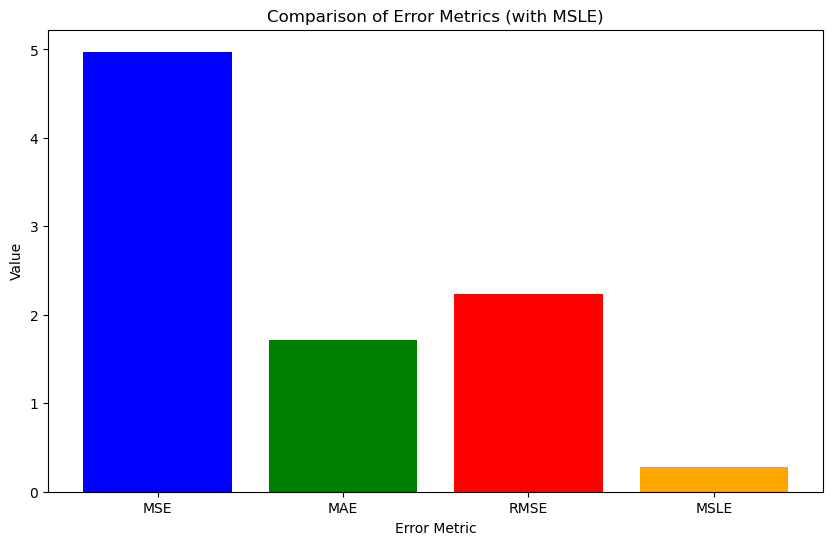

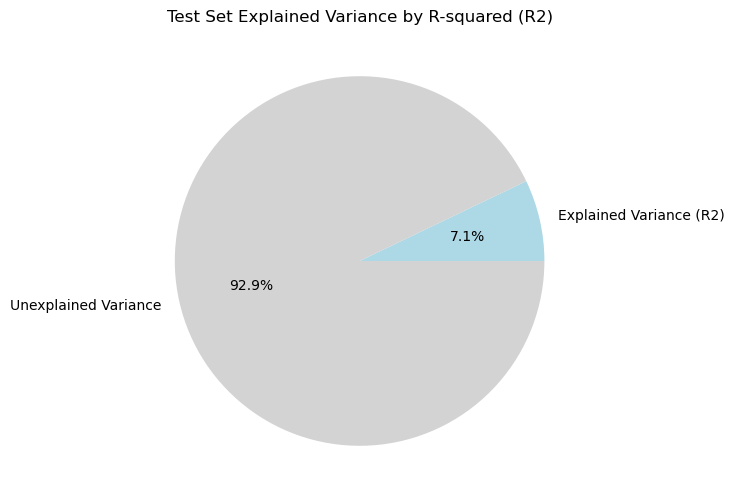

In [15]:
# Metrics calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred) * 100

print(f"Test Set MSE: {mse}")
print(f"Test Set MAE: {mae}")
print(f"Test Set RMSE: {rmse}")
print(f"Test Set R2: {r2}")

# Plotting MSLE if applicable
try:
    msle = mean_squared_log_error(y_test, y_pred)
    print(f"Test Set MSLE: {msle}")
    
    # Adding MSLE to the bar plot
    error_metrics = ['MSE', 'MAE', 'RMSE', 'MSLE']
    values = [mse, mae, rmse, msle]
    
    # Plot updated error metrics with MSLE
    plt.figure(figsize=(10, 6))
    plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'])  # Added orange for MSLE
    plt.xlabel('Error Metric')
    plt.ylabel('Value')
    plt.title('Comparison of Error Metrics (with MSLE)')
    plt.show()

except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
plt.show()

# External Validation Plots

External Validation Set MSE: 6.842355385668445
External Validation Set MAE: 2.0365892255471127
External Validation Set RMSE: 2.615789629474902
External Validation Set R2: -42.8246753658124
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


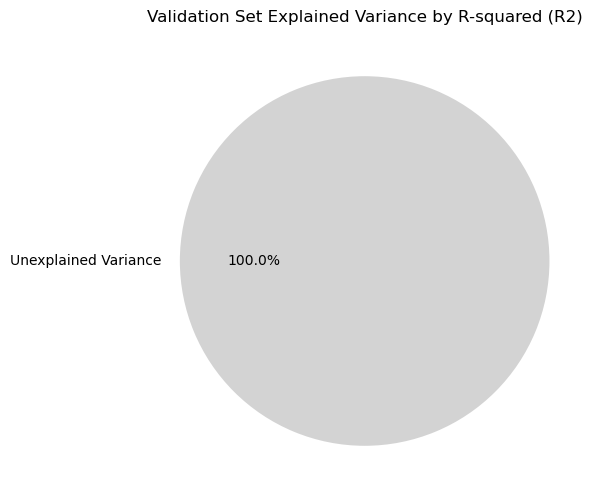

In [16]:
# Predict on the external validation set (eICU data)
y_pred_external = model.predict(X_external)

# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_pred_external)
mae_external = mean_absolute_error(y_external, y_pred_external)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_pred_external) * 100

print(f"External Validation Set MSE: {mse_external}")
print(f"External Validation Set MAE: {mae_external}")
print(f"External Validation Set RMSE: {rmse_external}")
print(f"External Validation Set R2: {r2_external}")

# Plotting MSLE if applicable
try:
    msle_external = mean_squared_log_error(y_external, y_pred_external)
    print(f"Test Set MSLE: {msle_external}")
    
    # Adding MSLE to the bar plot
    error_metrics = ['MSE', 'MAE', 'RMSE', 'MSLE']
    values = [mse, mae_external, rmse_external, msle_external]
    
    # Plot updated error metrics with MSLE
    plt.figure(figsize=(10, 6))
    plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'])  # Added orange for MSLE
    plt.xlabel('Error Metric')
    plt.ylabel('Value')
    plt.title('Comparison of Error Metrics (with MSLE)')
    plt.show()

except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
plt.show()

# Most important features

In [17]:
# Get feature importances
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Scale the importance
most_important_df['Importance'] *= 100000

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                        Feature   Importance
3                                          pCO2  7434.020191
42                                   Pain Level  3434.376419
60    Pulmonary Artery Pressure systolic (mmHg)  2995.721437
4                          Calculated Total CO2  2807.858959
22                                      INR(PT)  2577.647567
67                          Differential-Lymphs  2450.274676
1                                   Base Excess  2005.945705
27                                           PT  1836.820133
76                             PEEP set (cmH2O)  1798.816025
47                                          GCS  1708.699949
61   Pulmonary Artery Pressure diastolic (mmHg)  1693.349704
53          Arterial Blood Pressure mean (mmHg)  1513.734926
46                                      Albumin  1482.959650
59                                   Fibrinogen  1447.516773
31                            White Blood Cells  1413

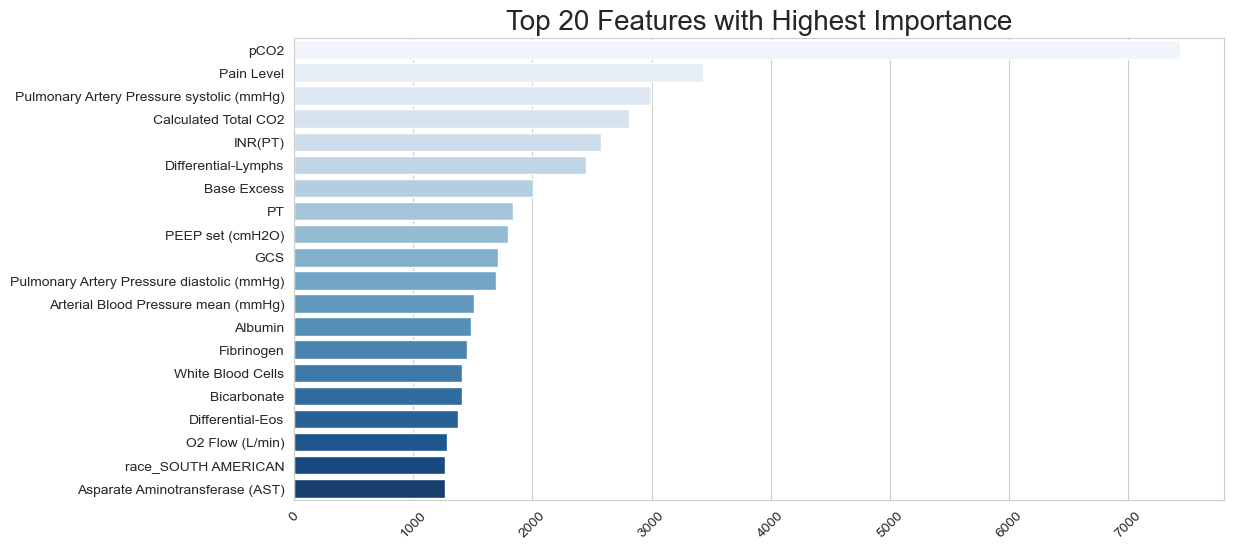

In [18]:
# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 10 most important features
top_10_features = most_important_df.head(20)

# Plotting
plt.figure(figsize=(12, 6))  # Reduce figure size
plot = sns.barplot(x='Importance', y='Feature', data=top_10_features, hue='Feature', palette="Blues", legend=False)

# Reduce font size slightly 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.title('Top 20 Features with Highest Importance', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.ylabel('')
plt.xlabel('')

# Save the plot in high resolution
#plt.savefig('plots/top_20_most_important_features.jpeg', dpi=300)
plt.show()